<a href="https://colab.research.google.com/github/jongwoonalee/jongwoonalee.github.io/blob/main/3D_Software_Renderer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D Software Renderer**

Importing functions

In [ ]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from math import atan, sin, cos
import numpy as np

# Part 1: Define the 3D cube centered at the origin with edge length 2

Creating 8 corners of the cube in 3D space
 1. Define a 3D-cube as a numpy array with 8 corners in 3D space centered on [0,0,0] and edge length 2, that is, 2 of the 8 diagonally-opposite corners have the coordinates [1,1,1] and [-1,-1,-1].

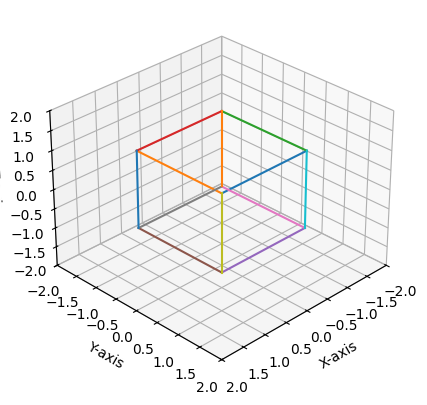

In [ ]:
vertices = np.array([ #꼭지점 넘버링
    [ 1,  1,  1],  # 0: front top right
    [-1,  1,  1],  # 1: front top left
    [ 1, -1,  1],  # 2: front bottom right
    [-1, -1,  1],  # 3: front bottom left
    [ 1,  1, -1],  # 4: back top right
    [-1,  1, -1],  # 5: back top left
    [ 1, -1, -1],  # 6: back bottom right
    [-1, -1, -1]   # 7: back bottom left
])

#  the edges of the cube - 0, 1, 2, 3, 4 등의 숫자는 각 꼭지점(corner)의 번호
edges = [
    (0, 1), (0, 2), (1, 3), (2, 3),  #  front - 앞면의 모서리들
    (4, 5), (4, 6), (5, 7), (6, 7),  # back - 뒷면의 모서리들
    (0, 4), (1, 5), (2, 6), (3, 7)   # connecting - 앞뒷면을 연결하는 모서리들
]

# Helper function to display the cube in 3D
def show_3d(vertices, edges):#꼭지점들의 좌표 배열 : vertices, 꼭지점 연결 배열; edges
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  # gca() 대신 add_subplot() 사용 # gca는 Matplotlib 라이브러리에서 "get current axes"의 약자입니다. 이 함수는 현재 활성화된 그래프의 축(axes) 객체를 반환
    for edge in edges:
        p1 = vertices[edge[0]] #각 모서리의 시작점(p1)
        p2 = vertices[edge[1]] #각 모서리의 끝점(p2)
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]]) # 각 좌표축별로 점들을 배열한 것입니다. 이 방식은 matplotlib의 3D 그래픽 함수가 요구하는 표준 형식
      # Set the view angle to one that clearly shows the cube is centered
    ax.view_init(elev=30, azim=45)

    # Set symmetric axis limits around zero
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    # Add grid for better spatial reference
    ax.grid(True)

    # Add axis labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.show()


# Display the initial 3D cube
show_3d(vertices, edges)

#Part 2: Create rotation and translation matrices for camera transformation

1.  let's start by moving our cube in front of the camera. For this, we will first do a transformation according to the extrinsic parameters of the camera (translation and rotation).
Here is a general definition of a rotation matrix around a vector u=[ux,uy,uz] with ||u||=1: (Rodrigues' rotation formula.)
Make a function for creating such a matrix, given a direction and an angle.

In [ ]:
def rotation_matrix(u, theta):#u: A vector representing the axis of rotation, theta: The angle of rotation in radians
    """
    Create a rotation matrix for rotation around vector u by angle theta (in radians)
    u should be a unit vector (|u| = 1)
    """
    # Ensure u is a unit vector
    u = np.array(u) # The function needs to perform vector operations, and NumPy provides efficient methods for these calculations. The user might pass u in various formats (a list, tuple, or already as a NumPy array), so converting it ensures consistency in how the vector is handled.
    u = u / np.linalg.norm(u) #np.linalg.norm() is a function from NumPy's linear algebra module that calculates the norm (or length/magnitude) of a vector. When applied to a vector, it computes the Euclidean norm (L2 norm), which is the square root of the sum of the squares of all elements in the vector.
                              #For a 3D vector u = [ux, uy, uz], the calculation is:||u|| = sqrt(ux² + uy² + uz²)
    ux, uy, uz = u # Extracting x, y, z components: Breaking down the vector into its individual components (ux, uy, uz) makes the code for constructing the rotation matrix cleaner and more readable. Instead of writing expressions like u[0]*u[1], the code can use the more intuitive variable names ux*uy. This improves code readability and reduces the chance of indexing errors when building the complex rotation matrix.

    # Components for the rotation matrix
    cos_theta = cos(theta)
    sin_theta = sin(theta)
    one_minus_cos = 1 - cos_theta

    # Construct the rotation matrix: actual 3×3 rotation matrix using Rodrigues' rotation formula.
    return np.array([
        [cos_theta + ux*ux*one_minus_cos, ux*uy*one_minus_cos - uz*sin_theta, ux*uz*one_minus_cos + uy*sin_theta],
        [uy*ux*one_minus_cos + uz*sin_theta, cos_theta + uy*uy*one_minus_cos, uy*uz*one_minus_cos - ux*sin_theta],
        [uz*ux*one_minus_cos - uy*sin_theta, uz*uy*one_minus_cos + ux*sin_theta, cos_theta + uz*uz*one_minus_cos]
    ])


2. Next, create a translation matrix using another helper function that you need to code. Use homogenous coordinates. Also remember to augment the rotation matrices accordingly so that they fit the homogenous calculations!!

    1) Here, we rotate first around the x-axis (u=[1,0,0]), then around the y-axis, then around the z-axis, and then we translate.
    
    Create a function get_extrinsic_matrix(position,orientation)that returns the final 4x4 extrinsic matrix based on homogenous coordinates.
    
    2) Next, write a function to_homogenous(points) that turns an array of points into homogenous coordinates [simply add a 1 as another dimension!].
    
    3) Write another function from_homogenous(points) that converts an array of homogenous coordinates into proper 3D or 2D coordinates [by dividing the first 2 or 3 coordinates by the third or fourth element
    
    Note, that these functions should work for both 3D and 2D input!!



In [ ]:
def homogeneous_rotation_matrix(u, theta):
    """
    Create a homogeneous 4x4 rotation matrix for rotation around vector u by angle theta
    """
    R = rotation_matrix(u, theta)
    # Convert to homogeneous coordinates (4x4 matrix)
    R_hom = np.eye(4) #Creates a 4×4 identity matrix
    R_hom[:3, :3] = R #Places the 3×3 rotation matrix in the top-left corner of the 4×4 matrix
    return R_hom

def translation_matrix(t):
    """
    Create a homogeneous 4x4 translation matrix for translation by vector t
    """
    T = np.eye(4)
    T[:3, 3] = t #Places the translation vector t in the first three rows of the last column
    return T

#1) Here, we rotate first around the x-axis (u=[1,0,0]), then around the y-axis, then around the z-axis, and then we translate.

def get_extrinsic_matrix(position, orientation):
    """
    Create the extrinsic matrix based on camera position and orientation
    Order: rotate around x, then y, then z, then translate

    position: [x, y, z] camera position in world coordinates
    orientation: [x_rot, y_rot, z_rot] rotation angles in radians
    """
    # Rotation matrices around each axis. Creates rotation matrices for rotations around the x, y, and z axes using the orientation angles
    #"orientation" typically refers to the rotation of an object or camera in 3D space. The orientation is often represented as three rotation angles around the three primary axes (x, y, and z). These angles are sometimes called Euler angles.
    Rx = homogeneous_rotation_matrix([1, 0, 0], orientation[0]) #[1, 0, 0] is the unit vector along the x-axis, orientation[0] is the rotation angle around the x-axis (in radians)
    Ry = homogeneous_rotation_matrix([0, 1, 0], orientation[1]) #[0, 1, 0] is the unit vector along the y-axis, orientation[1] is the rotation angle around the y-axis (in radians)
    Rz = homogeneous_rotation_matrix([0, 0, 1], orientation[2]) #[0, 0, 1] is the unit vector along the z-axis, orientation[2] is the rotation angle around the z-axis (in radians)

    # Translation matrix (negative because we're moving the world, not the camera)
    T = translation_matrix([-p for p in position])

    # Combine transformations: first rotate, then translate
    # The @ operator is matrix multiplication..The order is important!!!!: we apply transformations from right to left!!!!!!!!
    extrinsic = T @ Rz @ Ry @ Rx

    return extrinsic


##2) Next, write a function to_homogenous(points) that turns an array of points into homogenous coordinates [simply add a 1 as another dimension!].
##The function needs to handle both single points and arrays of points correctly.
#In NumPy, these have different shapes
def to_homogenous(points):
    """
    Convert array of points to homogeneous coordinates
    Works for both 2D and 3D points
    """
    # Get the number of points and dimensions
    if len(points.shape) == 1:
        # Single point
        return np.append(points, 1)#For a single point, it appends a 1 to the end of the point
    else:
        # Multiple points
        ones = np.ones((points.shape[0], 1))
        return np.hstack((points, ones))#for multiple points, it creates a column of 1s and horizontally stacks it with the points

def from_homogenous(points):
    """
    Convert array of homogeneous coordinates back to regular coordinates
    Works for both 2D and 3D points
    """
    if len(points.shape) == 1:
        # Single point:for a single point, it divides all but the last coordinate by the last coordinate
        return points[:-1] / points[-1]
    else:
        # Multiple points: For multiple points, it divides all but the last column by the last column (expanded to match the dimensions)
        return points[:, :-1] / points[:, -1:]

# Part 3: Transform the cube using extrinsic camera parameters
  Using camera_position = [0,0,-2.4], camera_orientation = [0,0.11,0], insert the necessary transformations to transform the cube into camera coordinates using the transformation from get_extrinsic_matrix and show the result using show_3d. You will need to convert back and forth from homogenous coordinates to do this...

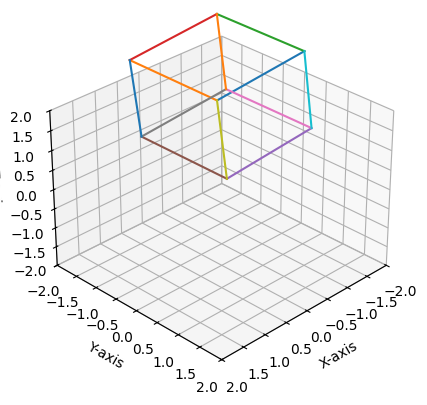

In [ ]:
# Camera parameters
camera_position = [0, 0, -2.4]#The camera is positioned 2.4 units back along the negative z-axis.
camera_orientation = [0, 0.11, 0] #The second value (0.11 radians, approximately 6.3 degrees) means a slight rotation around the y-axis (slight yaw).

# Get the extrinsic matrix: The function creates a 4×4 transformation matrix that converts from world coordinates to camera coordinates.
extrinsic_matrix = get_extrinsic_matrix(camera_position, camera_orientation) #Rotation around the y-axis (slight rotation), Translation (moving the world by the negative of the camera position)

# Convert vertices to homogeneous coordinates
vertices_homogeneous = to_homogenous(vertices) #to_homogenous() adds a fourth coordinate (1) to each vertex.

# Transform to camera coordinates.
#vertices_homogeneous.T transposes the vertices array to make each vertex a column. This is necessary for matrix multiplication.
vertices_camera_homogeneous = np.dot(extrinsic_matrix, vertices_homogeneous.T).T

# Convert back from homogeneous coordinates
#from_homogenous() converts the homogeneous coordinates back to regular 3D coordinates.
#It divides the first three coordinates of each vertex by the fourth coordinate.
#This step is necessary because the transformation could have changed the fourth coordinate from 1 to something else.
vertices_camera = from_homogenous(vertices_camera_homogeneous)

# Display the cube in camera coordinates
show_3d(vertices_camera, edges)



# Part 4: Create the intrinsic projection matrix
Next, let’s set up the intrinsic projection, including the projection matrix itself. Restrict the intrinsic matrix to only the focal length, such that
𝐾 = [𝑓0𝑠𝑥; 0𝑓𝑠𝑦; 001]

Make a function get_intrinsic_matrix(f,s) that creates the full intrinsic transformation including the projection matrix 3x4 P, so that we get a 3x4 matrix overall.

Again, this uses homogenous coordinates.
Using transform the camera coordinates into projected coordinates.

In order to use the helper-function show_2D from below, you will need to multiply the resulting coordinates by the size of the pixel canvas in pixels. So, we want to show an image of 250x250 pixels, you need to multiply all points by 250.



In [ ]:
def get_intrinsic_matrix(f, s):
    """
    Create the intrinsic projection matrix
    f: Focal length of the camera (a measure of how strongly the camera converges light)
     s: A tuple containing scaling factors (sx, sy) for the x and y dimensions
    """
    sx, sy = s #unpacks the scaling factors:

    # Intrinsic matrix K: camera calibration matrix
    # The focal length (f) scaled by the x and y scaling factors
    # No skew parameter (assumes perpendicular pixel axes)
    # No principal point offset (assumes the optical center is at the origin)
    K = np.array([
        [f*sx, 0, 0],
        [0, f*sy, 0],
        [0, 0, 1]
    ])

    # Projection matrix P (3x4)
    #This matrix is [I|0] where I is a 3×3 identity matrix and 0 is a zero column. It effectively drops the homogeneous coordinate.
    P = np.zeros((3, 4))
    P[:3, :3] = np.eye(3)  # Identity for first 3x3 block


    # Combined intrinsic transformation (3x4): This creates the final 3×4 intrinsic projection matrix.
    intrinsic = K @ P # (Explanation below. This operation has effectively "dropped" the w-coordinate from the 4D homogeneous point, preserving only the x, y, and z values
    return intrinsic


Why!! the projection matrix `P` is structured as `[I|0]` and why it "effectively drops the homogeneous coordinate":

In computer graphics and computer vision, projecting from 3D to 2D involves going from 3D homogeneous coordinates (x, y, z, w) to 2D homogeneous coordinates (x', y', w'). The projection matrix P performs this transformation.

When we create `P` as:
```python
P = np.zeros((3, 4))
P[:3, :3] = np.eye(3)  # Identity for first 3x3 block
```

We're setting up a 3×4 matrix that looks like this:
```
[1 0 0 0]
[0 1 0 0]
[0 0 1 0]
```

Now, let's see what happens when we multiply this matrix with a 3D homogeneous point (x, y, z, w):

```
[1 0 0 0] [x]   [x]
[0 1 0 0] [y] = [y]
[0 0 1 0] [z]   [z]
          [w]
```

The result is (x, y, z), which is now a 3D vector (in homogeneous coordinates for 2D space).

This operation has effectively "dropped" the w-coordinate from the 4D homogeneous point, preserving only the x, y, and z values. The z-coordinate will later be used for depth information or will be divided out when converting from homogeneous coordinates.

This is why we say it "effectively drops the homogeneous coordinate" - the w-value from the original 3D point isn't used in the resulting 2D projection. This is a standard approach in computer graphics for orthographic projection, where we simply discard the depth information to create a 2D representation.

When combined with the camera calibration matrix K, this projection process converts 3D points in camera space to 2D points on the image plane, which is exactly what we want for rendering 3D objects on a 2D screen.

# Part 5: Project 3D points to 2D using intrinsic matrix:
Insert the final code that projects the cube into an image and plot the result using show_2d. Again, conversion between homogenous coordinates has to be used...

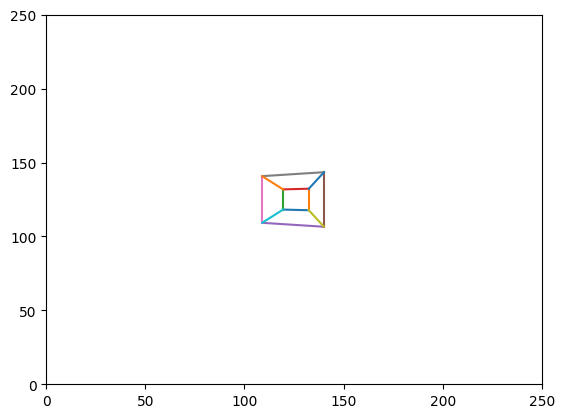

In [ ]:
# Camera parameters
f = 0.46 #Sets the focal length to 0.46 units.
s = (0.48, 0.52) #Sets the scaling factors to 0.48 for x and 0.52 for y. The different values mean pixels aren't perfectly square.

# Get the intrinsic matrix
intrinsic_matrix = get_intrinsic_matrix(f, s)

# Project to 2D
#Applies the intrinsic projection to the camera-space coordinates
#vertices_camera_homogeneous.T: Transposes the vertices to make each vertex a column vector.
#np.dot(intrinsic_matrix, ...): Multiplies each vertex by the intrinsic matrix.
vertices_projected_homogeneous = np.dot(intrinsic_matrix, vertices_camera_homogeneous.T).T

# Convert from homogeneous coordinates
#This divides by the homogeneous coordinate to get the final 2D positions. After this operation, the coordinates are normalized and typically range from -1 to 1.
#When we project 3D points to 2D using the intrinsic matrix, we get homogeneous 2D coordinates in the form
# (x', y', w'). These are not yet the final pixel coordinates. In projective geometry, the actual 2D position is obtained by dividing the first two coordinates by the third one: (x'/w', y'/w').
vertices_projected = from_homogenous(vertices_projected_homogeneous)

# Scale to image size (250x250 pixels)
image_size = (250, 250)
vertices_image = vertices_projected * image_size[0] #because [0]and [1]are the same..
#If not.
#vertices_image = np.zeros_like(vertices_projected)
#vertices_image[:, 0] = vertices_projected[:, 0] * image_size[0]  # x좌표에는 너비 적용
#vertices_image[:, 1] = vertices_projected[:, 1] * image_size[1]  # y좌표에는 높이 적용


# 이미지 중앙을 원점으로 이동하고 적절히 스케일링
vertices_image = np.zeros_like(vertices_projected)
vertices_image[:, 0] = vertices_projected[:, 0] * 100 + image_size[0]/2  # 스케일링 증가 및 중앙 이동
vertices_image[:, 1] = -vertices_projected[:, 1] * 100 + image_size[1]/2  # y축 반전, 스케일링 증가 및 중앙 이동

# Display the 2D projection
show_2d(vertices_image, edges, image_size)



# Bonus: Rotate the camera around the cube

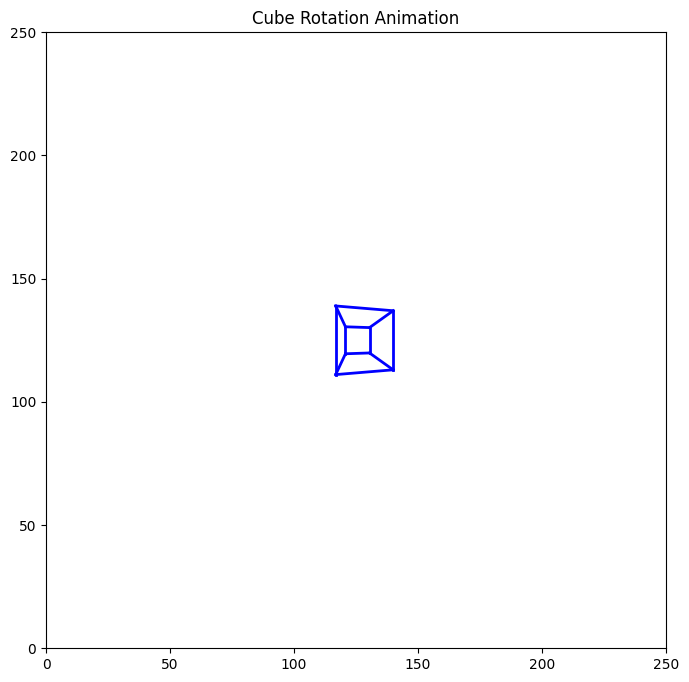

In [ ]:
import matplotlib.animation as animation#matplotlib의 animation 모듈
from IPython.display import HTML#IPython.display에서 HTML을 가져와 Jupyter Notebook에서 애니메이션을 표시할 수 있게 합니다.
#upyterLab 같은 인터랙티브 환경에서는 단순히 텍스트나 이미지뿐 아니라 HTML, JavaScript, CSS를 포함한 동적인 콘텐츠도 출력할 수 있습니다. 이 기능을 활용하면:애니메이션 (예: Matplotlib, Plotly, 기타 시각화 툴의 애니메이션)
#인터랙티브 위젯 (예: 슬라이더, 버튼) HTML 기반의 포맷팅된 출력 (예: 색상, 강조, 표) 등을 표시할 수 있습니다.


# 애니메이션 준비
fig, ax = plt.subplots(figsize=(8, 8))#8x8 인치 크기의 그림(figure)과 축(axis)
ax.set_xlim(0, 250)#x축과 y축의 범위를 0부터 250까지로 설정합니다.
ax.set_ylim(0, 250)
ax.set_title('Cube Rotation Animation')

# 큐브 모서리를 위한 라인 초기화
lines = []#큐브의 모서리(edge)를 그리기 위한 빈 라인 객체들을 생성합니다.
for edge in edges:
    line, = ax.plot([], [], 'b-', linewidth=2) #각 모서리에 대해 파란색('b')의 실선('-')으로, 두께가 2인 라인을 생성하고 빈 데이터로 초기화합니다.
    lines.append(line)#생성된 각 라인을 lines 리스트에 추가합니다.

def init():
    """애니메이션 초기화 함수"""
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    """각 프레임마다 실행되는 애니메이션 함수"""
    # 회전 각도 계산 (60프레임으로 완전한 회전)
    angle = i * 2 * np.pi / 60

    # 카메라 위치 계산
    x = 2.4 * np.sin(angle)
    z = -2.4 * np.cos(angle)
    camera_pos = [x, 0, z]

    # 카메라가 항상 원점을 향하도록 설정
    y_rot = np.arctan2(x, -z)
    camera_orient = [0, y_rot, 0]

    # 현재 카메라 각도에서 큐브 렌더링
    vertices_2d = render_view(camera_pos, camera_orient, f, s, (250, 250))

    # 각 모서리 라인 업데이트
    for j, line in enumerate(lines):
        p1 = vertices_2d[edges[j][0]]
        p2 = vertices_2d[edges[j][1]]
        line.set_data([p1[0], p2[0]], [p1[1], p2[1]])

    return lines

# 애니메이션 생성
ani = animation.FuncAnimation(
    fig, animate, frames=60,
    init_func=init, blit=True, interval=100
)

# Jupyter Notebook에서 표시
HTML(ani.to_jshtml())